# Lesson 2 : LangGraph Components

In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [11]:
# %pip install \
#     --config-settings="--global-option=build_ext" \
#     --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#     --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#     pygraphviz

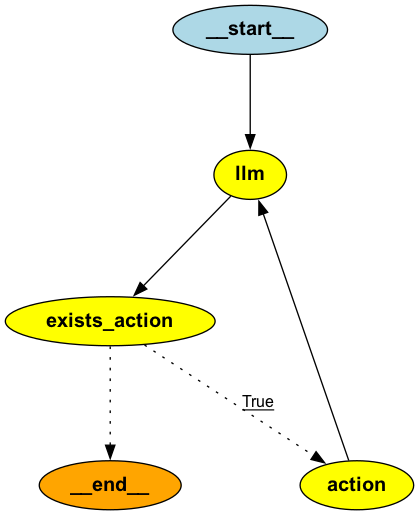

In [12]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [13]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_bV9gF8XyScTEte8sj6nrk8V4'}
Back to the model!


In [14]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bV9gF8XyScTEte8sj6nrk8V4', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e608bfbe-c51a-4eb7-9682-e52f8bc27636-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_bV9gF8XyScTEte8sj6nrk8V4'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1717824353, \'loca

In [15]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 57.0°F (13.9°C). The wind speed is 20.6 mph (33.1 km/h) coming from the west. The humidity is at 89%, and the visibility is 8.0 miles (14.0 km).'

In [16]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_aZqdAHvQOhFPkLzyZxulwjVF'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_wU6SSxBQLo1VjK2CHtm93UKR'}
Back to the model!


In [17]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 57.0°F. The wind speed is 20.6 mph coming from the west. The humidity is at 89% with a cloud cover of 75%.\n\nIn Los Angeles, it is overcast with a temperature of 64.9°F. The wind speed is 2.2 mph from the north, and the humidity is at 81% with a cloud cover of 100%.'

In [18]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl winner 2024'}, 'id': 'call_gj3IMoQg1SBtxFfj819TQ7Rl'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current GDP of Missouri 2024'}, 'id': 'call_v2OShj3hZe4Y2mdWeb4cYnYJ'}
Back to the model!


In [19]:
print(result['messages'][-1].content)

### GDP of Missouri
The most recent data available indicates that Missouri's GDP was approximately $336.63 billion in 2022. For the most current figures, you would need to refer to the latest release from the U.S. Bureau of Economic Analysis, usually updated quarterly.

### Summary
1. **Super Bowl Winner in 2024:** Kansas City Chiefs
2. **State of Winning Team’s Headquarters:** Missouri
3. **GDP of Missouri:** Approximately $336.63 billion in 2022 (latest available data)
